In [1]:
# Load packages
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/sod'

# Set path to be the directory:
os.chdir(path)

In [3]:
# Read the list of county codes:
cw = pd.read_excel('qcew-county-msa-csa-crosswalk.xlsx', sheet_name='Feb. 2013 Crosswalk')

cw['STCNTYBR'] = cw['County Code'].astype(str)
cw.loc[cw['STCNTYBR'].str.len() == 4, 'STCNTYBR'] = '0' + cw['STCNTYBR']

In [4]:
# Load branch data:
sod = pd.read_csv('sod_data.csv', header=0, sep=',')
#inst = pd.read_csv('sod_data_ins.csv', header=0, sep=',')

C:\Users\angel\AppData\Local\Temp\ipykernel_2844\2809252724.py:2: DtypeWarning: Columns (13,28,50,59,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  sod = pd.read_csv('sod_data.csv', header=0, sep=',')


In [5]:
sod['STCNTYBR'] = sod['STCNTYBR'].astype(str)
sod.loc[sod['STCNTYBR'].str.len() == 4, 'STCNTYBR'] = '0' + sod['STCNTYBR']

In [6]:
# Merge 'list' on 'STCNTYBR' with the sod data:
sod = pd.merge(sod, cw, on='STCNTYBR', how='left')

In [7]:
# show columns 13,28,50,59,60,62:
cols = [13,28,50,59,60,62]

# Specify dtypes for col 13, 28, 50, 59, 60, 62:
sod.iloc[:,cols].dtypes

DEPSUMBR    object
NECNAMB     object
ASSET       object
DEPDOM      object
DEPSUM      object
ESCROW      object
dtype: object

In [8]:
# Take commas away from columns 13, 28, 50, 59, 60, 62 so we can convert them to numeric:
sod.iloc[:,cols] = sod.iloc[:,cols].replace(',', '', regex=True)
#inst.iloc[:,cols] = inst.iloc[:,cols].replace(',', '', regex=True)

In [9]:
# Convert DEPSUMBR to numeric:
sod['DEPSUMBR'] = pd.to_numeric(sod['DEPSUMBR'], errors='coerce')

In [10]:
# Create an ID variable that is equal to RSSDHCR, and if RSSDHCR==0 then ID=RSSDID:
sod['ID'] = np.where(sod['RSSDHCR']==0, sod['RSSDID'], sod['RSSDHCR']) 

In [11]:
sod.groupby('RSSDID')['RSSDID'].head()

0           422406
1           422406
2           422406
3           422406
4           422406
            ...   
2669747    5692473
2669748    5784921
2669749    5784921
2669750    5784921
2669751    5784921
Name: RSSDID, Length: 74286, dtype: int64

In [12]:
# Is there a 1 to 1 map between RSSDID and CERT numbers?
sod.groupby('RSSDID').CERT.nunique().value_counts()


# Matches with Jason

CERT
1    15369
2      152
3        7
5        2
6        1
4        1
Name: count, dtype: int64

In [13]:
sod[sod['RSSDID']==480228]['CERT'].unique()

array([ 4892, 15802,  3510], dtype=int64)

In [14]:
sod[sod['RSSDID']==480228]['NAMEFULL'].unique()

array(['Nationsbank of North Carolina, National Association',
       'NationsBank, National Association (Carolinas)',
       'NationsBank, National Association',
       'Bank of America, National Association'], dtype=object)

In [15]:
sod[(sod['RSSDID']==480228) & (sod['NAMEFULL']=='Bank of America, National Association') & (sod['CERT']==3510)]['YEAR'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023], dtype=int64)

In [16]:
sod[(sod['RSSDID']==480228) & (sod['NAMEFULL']=='NationsBank, National Association') & (sod['CERT']==15802)]['YEAR'].unique()

array([1996, 1997, 1998, 1999], dtype=int64)

In [17]:
sod[(sod['RSSDID']==480228) & (sod['NAMEFULL']=='NationsBank, National Association (Carolinas)') & (sod['CERT']==15802)]['YEAR'].unique()

array([1995], dtype=int64)

In [18]:
sod[(sod['RSSDID']==480228) & (sod['NAMEFULL']=='Nationsbank of North Carolina, National Association') & (sod['CERT']==4892)]['YEAR'].unique()

array([1994], dtype=int64)

In [19]:
# Value in USD 
print('Deposits in 1996:', sod[sod['YEAR']==1996]['DEPSUMBR'].sum())

# Matches with Jason 

Deposits in 1996: 3328302607


In [20]:
# Create dataset excluding the HQ and NaN for the MSA Title:
df = sod[(sod['BKMO']==0) & (sod['MSA Title'].notnull())]

In [21]:
# Aggregate deposits over MSA per year, it will be useful later...
df_grouped_msa = df.groupby(['MSA Title', 'YEAR'])['DEPSUMBR'].sum().reset_index(name='total_msa')

# Aggregate all deposits over US per year:
df_grouped_msa['total_US'] = df_grouped_msa.groupby('YEAR')['total_msa'].transform('sum')

# Share of deposits in each MSA, per year:
df_grouped_msa['share_msa'] = df_grouped_msa['total_msa']/df_grouped_msa['total_US']

In [22]:
# Share of deposits in each MSA, per year:
df_grouped_msa['share_msa'] = df_grouped_msa['total_msa']/df_grouped_msa['total_US']

In [23]:
# Sanity check, sum of share_msa per year should be 1:
df_grouped_msa.groupby('YEAR')['share_msa'].sum()

YEAR
1994    1.0
1995    1.0
1996    1.0
1997    1.0
1998    1.0
1999    1.0
2000    1.0
2001    1.0
2002    1.0
2003    1.0
2004    1.0
2005    1.0
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.0
2022    1.0
2023    1.0
Name: share_msa, dtype: float64

In [24]:
# Compute the share of deposits per ID and year, note that the total deposits per MSANAMB is in the df_grouped dataset:
df = pd.merge(df, df_grouped_msa, on=['MSA Title', 'YEAR'], how='left')

# Sort values by MSA and year:
df = df.sort_values(by=['MSA Title', 'YEAR'])

In [25]:
df[df['ID']==0] # matches with jason until here

,YEAR,CERT,BRNUM,UNINUMBR,NAMEFULL,ADDRESBR,CITYBR,CNTYNAMB,STALPBR,ZIPBR,...,County Code,County Title,MSA Code,MSA Title,CSA Code,CSA Title,ID,total_msa,total_US,share_msa
454393,2000,35329,3,290911.0,Beacon Federal,7 Technology Park Drive,Westford,Middlesex,MA,1886.0,...,25017.0,"Middlesex County, Massachusetts",C1446,"Boston-Cambridge-Newton, MA-NH MSA",CS148,"Boston-Worcester-Providence, MA-RI-NH-CT CSA",0,74864134,2720908939,0.027514
523466,2001,35329,3,290911.0,Beacon Federal,7 Technology Park Drive,Westford,Middlesex,MA,1886.0,...,25017.0,"Middlesex County, Massachusetts",C1446,"Boston-Cambridge-Newton, MA-NH MSA",CS148,"Boston-Worcester-Providence, MA-RI-NH-CT CSA",0,73718798,2898566377,0.025433
523045,2001,34966,1,359307.0,First Capital Bank,1503 Atkinson St,Laurinburg,Scotland,NC,28352.0,...,37165.0,"Scotland County, North Carolina",C2990,"Laurinburg, NC MicroSA",CS246,"Fayetteville-Lumberton-Laurinburg, NC CSA",0,265636,2898566377,0.000092
592438,2002,34966,1,359307.0,First Capital Bank,909 S Main St,Laurinburg,Scotland,NC,28352.0,...,37165.0,"Scotland County, North Carolina",C2990,"Laurinburg, NC MicroSA",CS246,"Fayetteville-Lumberton-Laurinburg, NC CSA",0,278831,3107570722,0.000090
454392,2000,35329,1,290909.0,Beacon Federal,5248 Manchester Highway,Morrison,Warren,TN,37357.0,...,47177.0,"Warren County, Tennessee",C3266,"McMinnville, TN MicroSA",NaN,NaN,0,296897,2720908939,0.000109
523465,2001,35329,1,290909.0,Beacon Federal,5248 Manchester Highway,Morrison,Warren,TN,37357.0,...,47177.0,"Warren County, Tennessee",C3266,"McMinnville, TN MicroSA",NaN,NaN,0,304804,2898566377,0.000105
454394,2000,35329,5,290913.0,Beacon Federal,765 West Poplar Avenue,Collierville,Shelby,TN,38017.0,...,47157.0,"Shelby County, Tennessee",C3282,"Memphis, TN-MS-AR MSA",CS368,"Memphis-Forrest City, TN-MS-AR CSA",0,9874455,2720908939,0.003629
523467,2001,35329,5,290913.0,Beacon Federal,765 West Poplar Avenue,Collierville,Shelby,TN,38017.0,...,47157.0,"Shelby County, Tennessee",C3282,"Memphis, TN-MS-AR MSA",CS368,"Memphis-Forrest City, TN-MS-AR CSA",0,10484072,2898566377,0.003617
454391,2000,35329,4,290912.0,Beacon Federal,"509 Enon Springs Road East, Suite 1",Smyrna,Rutherford,TN,37167.0,...,47149.0,"Rutherford County, Tennessee",C3498,"Nashville-Davidson--Murfreesboro--Franklin, TN...",CS400,"Nashville-Davidson--Murfreesboro, TN CSA",0,15923725,2720908939,0.005852
523463,2001,35329,4,290912.0,Beacon Federal,105 Threet Industrial Road,Smyrna,Rutherford,TN,37167.0,...,47149.0,"Rutherford County, Tennessee",C3498,"Nashville-Davidson--Murfreesboro--Franklin, TN...",CS400,"Nashville-Davidson--Murfreesboro, TN CSA",0,15742913,2898566377,0.005431


In [26]:
# Write a .csv file with df[df['ID']==0]:
df[df['ID']==0].to_csv('sod_data_no_id.csv', index=False)

In [27]:
df[df['ID']==0]['RSSDHCR']

454393    0
523466    0
523045    0
592438    0
454392    0
523465    0
454394    0
523467    0
454391    0
523463    0
454390    0
523464    0
Name: RSSDHCR, dtype: int64

In [28]:
# Compute the total amount of deposits per NAMEHCR, in each MSA and year:
df_grouped_id = df.groupby(['ID', 'MSA Title', 'YEAR'])['DEPSUMBR'].sum().reset_index(name='total_id')

df = pd.merge(df, df_grouped_id, on=['ID', 'MSA Title', 'YEAR'], how='left')

In [29]:
# Compute share of deposits per NAMEHCR, in each MSA and year:
df['share_id'] = 100*(df['total_id']/df['total_msa'])
df['share_id_sq'] = df['share_id']**2


In [30]:
# Take the columns ID, YEAR, MSANAMB, and share_id_sq and take uniques on IDs, keep only those columns:
df_grouped_id_sq = df[['ID', 'YEAR', 'MSA Title','share_id_sq']].drop_duplicates()
 

In [31]:
# Sum all the share_id_sq per MSANAMB and year:
df_grouped_id_sq = df_grouped_id_sq.groupby(['MSA Title', 'YEAR'])['share_id_sq'].sum().reset_index(name='HHI')

In [32]:
df_grouped_id_sq[df_grouped_id_sq['HHI']==10000]

,MSA Title,YEAR,HHI
121,"Adjuntas, PR MicroSA",1995,10000.0
122,"Adjuntas, PR MicroSA",1996,10000.0
123,"Adjuntas, PR MicroSA",1997,10000.0
124,"Adjuntas, PR MicroSA",1998,10000.0
125,"Adjuntas, PR MicroSA",1999,10000.0
...,...,...,...
27833,"Zapata, TX MicroSA",2019,10000.0
27834,"Zapata, TX MicroSA",2020,10000.0
27835,"Zapata, TX MicroSA",2021,10000.0
27836,"Zapata, TX MicroSA",2022,10000.0


In [33]:
df_grouped_id_sq[df_grouped_id_sq['HHI']==10000]

,MSA Title,YEAR,HHI
121,"Adjuntas, PR MicroSA",1995,10000.0
122,"Adjuntas, PR MicroSA",1996,10000.0
123,"Adjuntas, PR MicroSA",1997,10000.0
124,"Adjuntas, PR MicroSA",1998,10000.0
125,"Adjuntas, PR MicroSA",1999,10000.0
...,...,...,...
27833,"Zapata, TX MicroSA",2019,10000.0
27834,"Zapata, TX MicroSA",2020,10000.0
27835,"Zapata, TX MicroSA",2021,10000.0
27836,"Zapata, TX MicroSA",2022,10000.0


In [34]:
# sum the squared shares of deposits per MSA, per year:
df_HHI = df_grouped_id_sq[['YEAR', 'MSA Title', 'HHI']].drop_duplicates()

In [35]:
df_HHI = pd.merge(df_HHI, df_grouped_msa, on=['MSA Title', 'YEAR'], how='left')

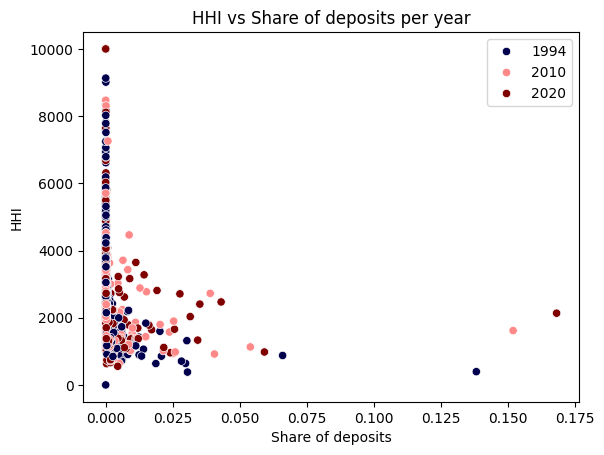

In [36]:
# plot a scatter plot of the HHI per share_msa per year, I want the dots for each year to have different collors, and 
# to be in different plots:
df_HHI_some_years = df_HHI[(df_HHI['YEAR']==1994) | (df_HHI['YEAR']==2010) | (df_HHI['YEAR']==2020) ]
sns.scatterplot(data=df_HHI_some_years, x='share_msa', y='HHI', hue='YEAR', palette='seismic')
plt.legend()
plt.title('HHI vs Share of deposits per year')
plt.xlabel('Share of deposits')
plt.ylabel('HHI')
plt.savefig('HHI_vs_share_deposits.png')
plt.show()


Text(0, 0.5, 'HHI')

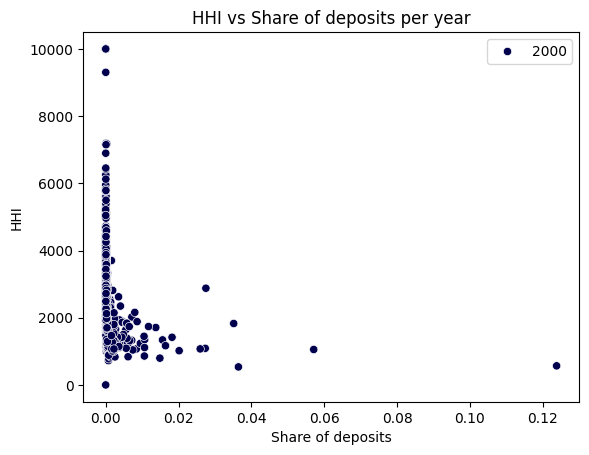

In [37]:
# I want to make the same plot as above, but only for 1994 and 2022:
df_HHI_2000 = df_HHI[(df_HHI['YEAR']==2000)]

sns.scatterplot(data=df_HHI_2000, x='share_msa', y='HHI', hue='YEAR', palette='seismic')
plt.legend()
plt.title('HHI vs Share of deposits per year')
plt.xlabel('Share of deposits')
plt.ylabel('HHI')


Text(0, 0.5, 'HHI')

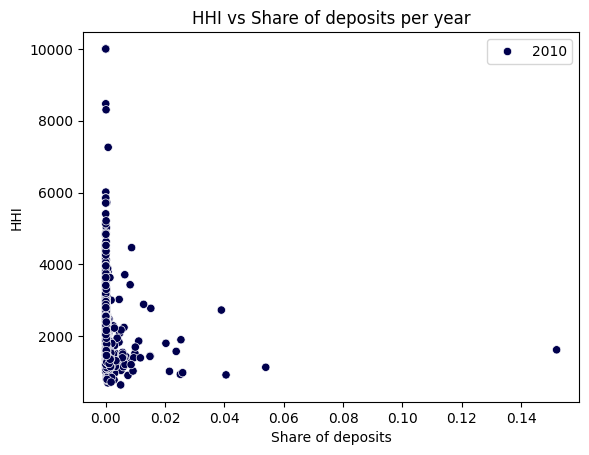

In [38]:
# I want to make the same plot as above, but only for 1994 and 2022:
df_HHI_2010 = df_HHI[(df_HHI['YEAR']==2010)]

sns.scatterplot(data=df_HHI_2010, x='share_msa', y='HHI', hue='YEAR', palette='seismic')
plt.legend()
plt.title('HHI vs Share of deposits per year')
plt.xlabel('Share of deposits')
plt.ylabel('HHI')


Text(0, 0.5, 'HHI')

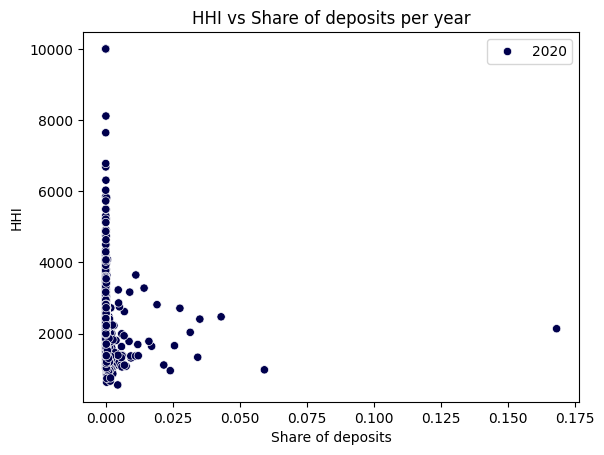

In [39]:
# I want to make the same plot as above, but only for 1994 and 2022:
df_HHI_2020 = df_HHI[(df_HHI['YEAR']==2020)]

sns.scatterplot(data=df_HHI_2020, x='share_msa', y='HHI', hue='YEAR', palette='seismic')
plt.legend()
plt.title('HHI vs Share of deposits per year')
plt.xlabel('Share of deposits')
plt.ylabel('HHI')


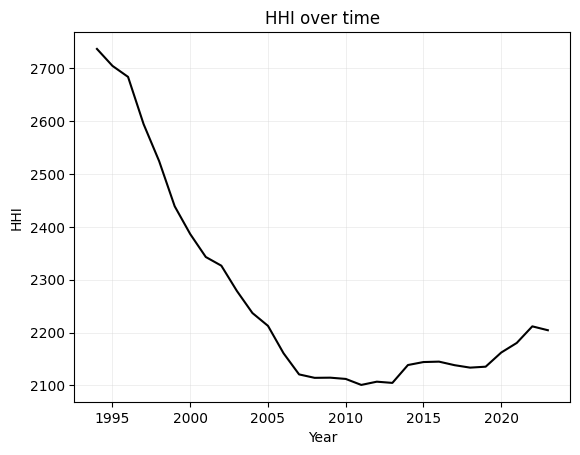

In [40]:
# Aggregate to get one HHI per year, averaging over MSAs:
df_HHI = df_HHI.groupby('YEAR')['HHI'].mean().reset_index(name='HHI')

# Plot HHI over time:
plt.plot(df_HHI['YEAR'], df_HHI['HHI'], color='black')
plt.xlabel('Year')
plt.ylabel('HHI')
plt.title('HHI over time')
plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.savefig('HHI_over_time.svg')
plt.show()

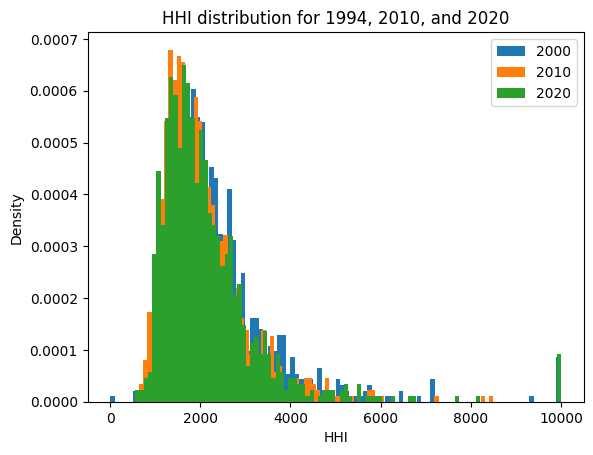

In [41]:
# Plot the histogram of HHI for 1994, 2010, and 2020. Please use fraction of observations in the y-axis:
plt.hist(df_HHI_2000['HHI'], bins=100, alpha=1, label='2000', density=True)
plt.hist(df_HHI_2010['HHI'], bins=100, alpha=1, label='2010', density=True)
plt.hist(df_HHI_2020['HHI'], bins=100, alpha=1, label='2020', density=True)
plt.legend()
plt.xlabel('HHI')
plt.ylabel('Density')
plt.title('HHI distribution for 1994, 2010, and 2020')
plt.savefig('HHI_distribution.png')
plt.show()




 

In [42]:
# temporary dataset
temp = df[['ID', 'YEAR', 'MSA Title', 'share_id_sq', 'share_msa']].drop_duplicates()

# compute HHI per MSA and year
wHHI = temp.groupby(['MSA Title', 'YEAR'])['share_id_sq'].sum().reset_index(name='HHI')

df_wHHI = pd.merge(df[['MSA Title', 'YEAR', 'share_msa']], wHHI, on=['MSA Title', 'YEAR'], how='left').drop_duplicates()


In [43]:
# Average HHI over MSAs, weighting by 'share_msa' to get one value per year:
df_wHHI['wHHI'] = df_wHHI['HHI']*df_wHHI['share_msa']

# sum wHHI variable per year:
df_wHHI = df_wHHI.groupby('YEAR')['wHHI'].sum().reset_index(name='wHHI')


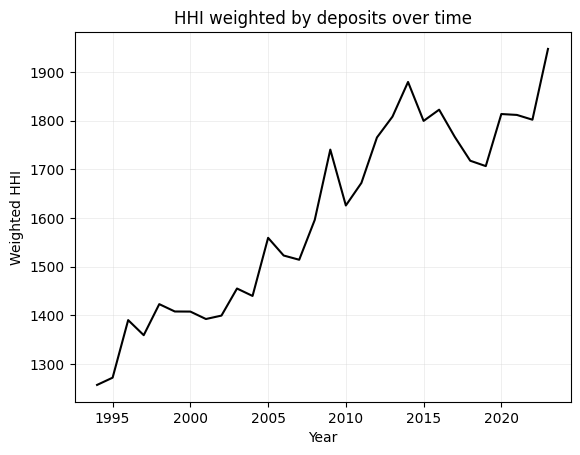

In [44]:
# plot wHHI over time:
plt.plot(df_wHHI['YEAR'], df_wHHI['wHHI'], color='black')
plt.xlabel('Year')
plt.ylabel('Weighted HHI')
plt.title('HHI weighted by deposits over time')
plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.5)
plt.savefig('wHHI_over_time.svg')
plt.show()